# LIBRARIES IMPORT

In [1]:
import CNN_lib
import CNN_utilities
import fig_lib 

import numpy as np
import matplotlib.pyplot as plt

import pickle
import json

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report

# SETTINGS

In [2]:
trains_n=5

data_split='rnd_patients'                                # 'rnd_recs' 'rnd_patients'

checking_on=False
t_btw_frm=0.05
check_record_1= '670615_19'
check_record_2= 'ROT_670615_19'

In [3]:
# -------- MODEL --------

mdl = 'Test'
opt='adam'
lss='binary_crossentropy'

# -------- TRAINNING --------

epochs=3

### DATA SPLIT

In [4]:
if data_split == 'rnd_recs': test_size=0.2           

elif data_split == 'rnd_patients': val_pat_0,val_pat_1 = 10 , 5

### DATA AUGMENTATION

In [5]:
n_flip_1,n_flip_0=0.7 , 0.07

n_rot_1,n_rot_0=1 , 0.07

n_contr_1,n_contr_0=0.4 , 0.04

n_bright_1,n_bright_0=0.4 , 0.04

### PATHS

In [6]:

checkpoint_path = "C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static/checkpoints"
pkl_train_p='C:\PROJECTS\emboendo\CNN/pikles/processed_train_d.pkl'   
check_points_p = [checkpoint_path+'_'+str(n)+'.h5' for n in range(trains_n)]

if data_split == 'rnd_patients': json_fix_sq_p='C:\PROJECTS\emboendo\dicom_viewer\_static\Jsons\points_fix_d.json'

# GENERATE TRAIN DATA

In [7]:
if data_split == 'rnd_patients':

    with open(json_fix_sq_p, 'r') as json_file:
        json_d = json.load(json_file)

    patients_d_df =  CNN_utilities.gen_patients_d_df(json_d)

In [8]:
with open(pkl_train_p, 'rb') as pikle_file:

    save_trains= pickle.load(pikle_file)

x_train,y_train,rcs =  save_trains[0],save_trains[1],save_trains[2]

max_frm_n, HEIGHT, WIDTH=np.shape(x_train)[1],np.shape(x_train)[2],np.shape(x_train)[3]


### MODEL

In [9]:
input_shape=(max_frm_n, HEIGHT, WIDTH, 1)

modelos=[]

for _ in check_points_p:

  model = models.Sequential([
          layers.Conv3D(filters=16, kernel_size=(3, 3, 1), activation='relu',input_shape=input_shape),
          layers.MaxPooling3D(pool_size=(2, 2, 2)),
          layers.Conv3D(filters=32, kernel_size=(3, 3, 1),  activation='relu'),
          layers.MaxPooling3D(pool_size=(2, 2, 2)),
          layers.Conv3D(filters=32, kernel_size=(3, 3, 1),  activation='relu'),
          layers.MaxPooling3D(pool_size=(2, 2, 2)),
          layers.Conv3D(filters=16, kernel_size=(1, 1, 5),  activation='relu'),
          layers.Flatten(),
          layers.Dropout(0.2),
          layers.Dense(64, activation='relu'),
          layers.Dense(1,activation='sigmoid')
          ])
    
  model.compile(optimizer=opt, loss=lss, metrics=['accuracy'])
  modelos.append(model)

model.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 38, 158, 160, 16   160       
                             )                                   
                                                                 
 max_pooling3d_12 (MaxPooli  (None, 19, 79, 80, 16)    0         
 ng3D)                                                           
                                                                 
 conv3d_17 (Conv3D)          (None, 17, 77, 80, 32)    4640      
                                                                 
 max_pooling3d_13 (MaxPooli  (None, 8, 38, 40, 32)     0         
 ng3D)                                                           
                                                                 
 conv3d_18 (Conv3D)          (None, 6, 36, 40, 32)     9248      
                                                    

In [10]:
checkpoints=[ModelCheckpoint(pp, save_best_only=True, monitor='val_loss',   mode='min', verbose=1) for pp in check_points_p]

### DATA INPUT CHECK 

In [11]:
if checking_on:

    for x,y,r in zip(x_train,y_train,rcs):print(r,int(y),np.shape(x),type(x))

I1 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I11 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I2 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I9 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I28 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I33 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I38 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I39 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I40 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I42 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I44 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I45 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I47 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I49 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I51 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I53 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I54 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I56 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I57 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I58 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I61 0 (40, 160, 160, 1) <class 'numpy.ndarr

670615_19  Label: 1


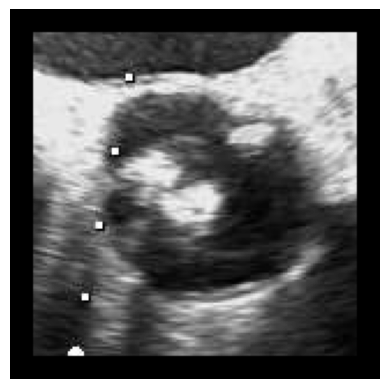

In [12]:
if checking_on: CNN_utilities.simple_check(check_record_1,rcs,x_train,y_train)

#  CNN TRAINNING

670615_19  Label: 1


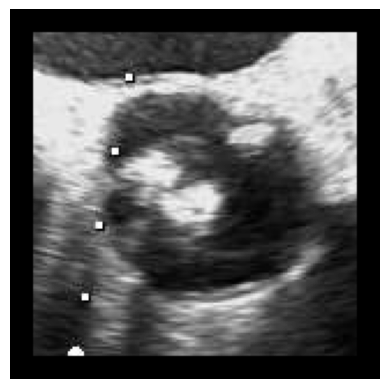

I672 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I870 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I168 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I709 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
380772_9 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I604 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I38 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I830 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I925 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I115 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
670615_2 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
670615_16 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I335 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
670615_10 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I687 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I1118 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I161 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
178572_6 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I103 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I39 0 (40, 160, 160, 1) <class 'numpy.ndarray'>

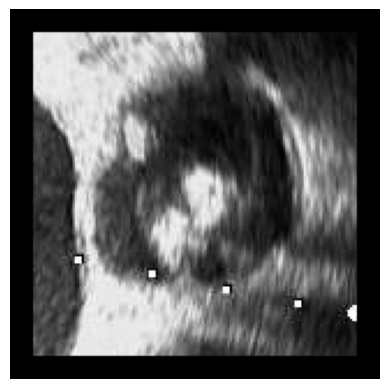

ROT_I72 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I584 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I117 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
656960_2 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
ROT_I674 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I828 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I839 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I278 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
CNTR_656960_1 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
ROT_I1160 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I741 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
CNTR_I855 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I54 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
ROT_I623 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
224436_12 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
ROT_I1078 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
ROT_I1018 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I1279 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
ROT_I335 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
ROT_I676 1 (40, 

c:\PROJECTS\EMBOENDO\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - ETA: 0s - loss: 0.5908 - accuracy: 0.6863
Epoch 2: val_loss did not improve from 0.77989
32/32 [==============================] - 16s 498ms/step - loss: 0.5908 - accuracy: 0.6863 - val_loss: 0.9453 - val_accuracy: 0.3265
Epoch 3/3
32/32 [==============================] - ETA: 0s - loss: 0.5206 - accuracy: 0.7453
Epoch 3: val_loss improved from 0.77989 to 0.77617, saving model to C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static\checkpoints_0.h5
32/32 [==============================] - 16s 500ms/step - loss: 0.5206 - accuracy: 0.7453 - val_loss: 0.7762 - val_accuracy: 0.4592
 
-------------- ITERATION 1/5 COMPLETED --------------
 
No Luck
385597_12 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
656335_7 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
539258_1 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I674 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
656335_2 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I45 0 (40, 160, 16

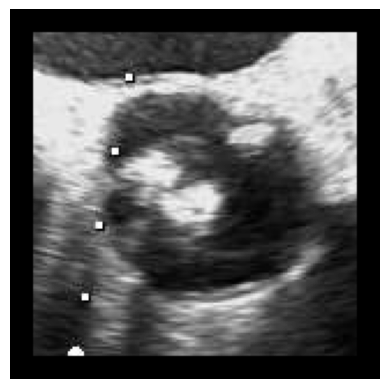

I697 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I1096 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I468 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I189 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I1117 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I40 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I1124 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I724 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I103 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I606 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
6272_16 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I713 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
224436_11 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
660022_6 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
651399_4 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
646778_7 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
673676_26 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
670615_10 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
385597_8 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
380772_1 0 (40, 160, 160, 1) <cla

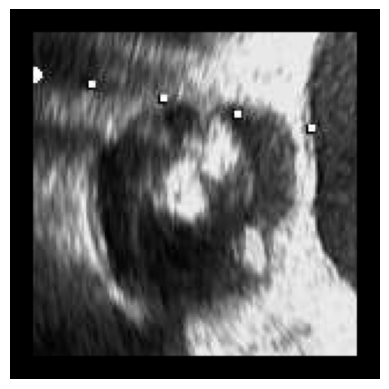

673676_20 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I828 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I685 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I191 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I588 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
ROT_I1136 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
178572_5 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
ROT_669183_1 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I42 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
BRGHT_656960_7 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I70 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
673676_16 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I713 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
ROT_272340_6 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
ROT_669183_5 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
FLIP_I202 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I131 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
ROT_I929 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I1183 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
ROT_6706

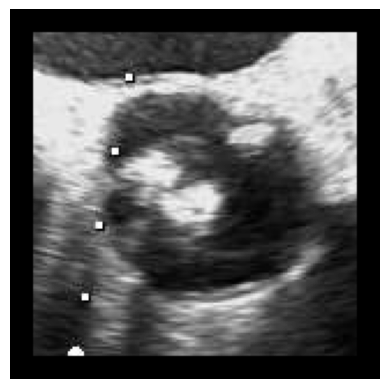

I833 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I550 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I898 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I95 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
547169_3 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I1286 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I723 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I914 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I712 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I656 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
660022_2 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
670615_2 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
272340_4 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I622 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
380772_1 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I203 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I238 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I604 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I546 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I1107 0 (40, 160, 160, 1) <class 'numpy.ndarray'>

KeyboardInterrupt: 

In [13]:
iter=0
histories=[]

for md, chk_p in zip(modelos,checkpoints):

    X_d,Y_d,recs=CNN_lib.shuffle(x_train,y_train,rcs)                                                                                                                                                      # SHUFFLE

    if data_split=='rnd_recs': X_train_spl, X_eval_spl, Y_train_spl, Y_eval_spl ,recs_train,recs_eval=CNN_utilities.random_split_by_recs(X_d, Y_d,recs, test_size=test_size)                               # SPLIT
    else: X_train_spl, X_eval_spl, Y_train_spl, Y_eval_spl ,recs_train,recs_eval=CNN_utilities.random_split_by_patients(patients_d_df,recs,X_d,Y_d, val_pat_0=val_pat_0, val_pat_1=val_pat_1)

    X_eval,Y_eval=X_eval_spl,Y_eval_spl

    if checking_on: CNN_utilities.in_loop_check(check_record_1,recs_train,X_train_spl,Y_train_spl)                                                                                                            # CHECK

    X_train_spl, Y_train_spl, recs_train = CNN_lib.d_augmentation_logic_encapsulation(X_train_spl,Y_train_spl,recs_train,n_flip_1,n_flip_0,n_rot_1,n_rot_0,n_contr_1,n_contr_0,n_bright_1,n_bright_0)      # AUGMENTATION

    X_train,Y_train,recs_train_f=CNN_lib.shuffle(X_train_spl,Y_train_spl,recs_train)                                                                                                                       # SHUFFLE
    
    if checking_on: CNN_utilities.in_loop_check(check_record_2,recs_train_f,X_train,Y_train)                                                                                                                  # CHECK

    hist=md.fit(X_train, Y_train, epochs=epochs, validation_data=(X_eval,Y_eval),callbacks=[chk_p])                                                                                                         # TRAIN
    histories.append(hist)
    
    iter+=1
    print(' ')
    print(f'-------------- ITERATION {iter}/{trains_n} COMPLETED --------------')
    print(' ')

In [ ]:
modelos =[ load_model(pp) for pp in check_points_p]

# EVALUATE MODEL

In [ ]:
for history in histories: CNN_lib.plot_train_eval(history,epochs)

In [ ]:
loss,accuracy= [],[]

for model in modelos:

    test_loss, test_accuracy = model.evaluate(X_eval,Y_eval,verbose=0) 

    loss.append(test_loss)
    accuracy.append(test_accuracy)

# ROC CURVE

In [ ]:
roc_aucs = []

for model in modelos:

    predictions = model.predict(X_eval)

    fpr_val, tpr_val, thresholds_val = roc_curve(Y_eval, predictions)
    roc_auc_false = auc(fpr_val, tpr_val)
    roc_aucs.append(roc_auc_false)

    #CNN_lib.plot_roc_curve(fpr_val,tpr_val,roc_auc_false)

In [ ]:
CNN_lib.list_plot(roc_aucs,title='AUCS',ylabel='Roc AUC')

In [ ]:
print( 'AUC')
CNN_lib.stats(roc_aucs)

In [ ]:
print( 'LOSS')
CNN_lib.stats(loss)

In [ ]:
print( 'ACCURACITY')
CNN_lib.stats(accuracy,rnd=4)

#  FORECAST EVALUATION

In [ ]:

predictions_raw=[]

trsh=0.35

for pred in predictions:

    if pred < trsh:predictions_raw.append(0)
    else:predictions_raw.append(1)

predictions_raw=np.array(predictions_raw)


In [ ]:
conf_matrix = confusion_matrix(Y_eval, predictions_raw)

print("Matriz de Confusión:")
print(conf_matrix)

# Obtener el informe de clasificación
classification_report_str = classification_report(Y_eval, predictions_raw)
print("Informe de Clasificación:")
print(classification_report_str)



In [ ]:
true_classes = Y_eval  

correctly_classified_indices = np.where(predictions_raw == true_classes)[0]
incorrectly_classified_indices = np.where(predictions_raw != true_classes)[0]

correctly_classified_video_ids = [video_id for video_id in correctly_classified_indices]
incorrectly_classified_video_ids = [video_id for video_id in incorrectly_classified_indices]

num_zeros = np.count_nonzero(Y_eval == 0)
num_ones = np.count_nonzero(Y_eval == 1)


In [ ]:
correct_labels_val = [Y_eval[i] for i in correctly_classified_indices]

print(correct_labels_val)

In [ ]:
print(f"OK, {len(correctly_classified_video_ids)}")
print(f"BAD, {len(incorrectly_classified_video_ids)}")
print(f'Ratio forecast: {len(correctly_classified_video_ids)/len(incorrectly_classified_video_ids)}')
print(f'Ratio labeling: {max([num_ones,num_zeros])/min([num_ones,num_zeros])}')